# Lab 5: Introduction to Classification

### Introduction

In this lab we will play a little with data classification. We will deal with the famous [Iris flower dataset](http://archive.ics.uci.edu/ml/datasets/Iris). 

We will first visualise its features and will then train a simple classifier to predict the class of unknown samples. 

We finally will __qualitatively__ analyse the results. This means that we will only observe the results in a graphical way and try to make sense of the classifier's behaviour. In the next lab, instead, we will analyse the results in a __quantitative__ way, i.e. by using some metric that quantifies the performance of the classifier.

__Note__: you will need to reuse much of the code you'll write here for the next lab sessions, __as well as for Coursework 2__. You should thus try to write your code as neat and reusable as you can (i. e. use functions!).

As usual, let's import the libraries before we start by running the cell below.

In [1]:
from __future__ import print_function # to avoid issues between Python 2 and 3 printing

import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint
from voronoi import plot_voronoi

# show matplotlib figures inline
%matplotlib inline

In [2]:
# By default we set figures to be 12"x8" on a 110 dots per inch (DPI) screen 
# (adjust DPI if you have a high res screen!)
plt.rc('figure', figsize=(12, 8), dpi=110)
plt.rc('font', size=12)

## The Iris flower dataset

The Iris Flower Dataset is a classic in machine learning. It contains 150 samples, each describing four different characteristics of the [Iris Flower](https://en.wikipedia.org/wiki/Iris_(plant)):

1. sepal length
2. sepal width
3. petal length
4. petal width

All features are expressed in centimetres. The dataset contains samples from three different species of Iris flowers: 

1. Iris Setosa
2. Iris Versicolour
3. Iris Virginica

There are 50 samples for each species. We split the dataset in two sets: a __training__ set, containing 100 samples, which will be used for training a classifier, and a __test__ set, containing 50 samples, which will be used to evaluate the classifier.

Run the cell below to load the dataset in memory.

In [4]:
# load the iris train and test sets

def load_iris_data(train_path='iris_train.csv', test_path='iris_test.csv'):
    train_set = np.loadtxt(train_path, delimiter=',')
    test_set = np.loadtxt(test_path, delimiter=',')

    # separate labels from features
    train_labels = train_set[:, 4].astype(np.int)
    train_set = train_set[:, 0:4]
    test_labels = test_set[:, 4].astype(np.int)
    test_set = test_set[:, 0:4]
    
    return train_labels, train_set, test_labels, test_set

train_labels, train_set, test_labels, test_set = load_iris_data()

`train_set` and `test_set` are NumPy arrays of shape `(100, 4)` and `(50, 4)` respectively. Rows correspond to individual samples, while columns correspond to the aforementioned flowers' characteristics.
`train_labels` and `test_labels` are NumPy arrays of shape `(100,)` and `(50,)` and contain the class/species label of each sample, i.e. either 1, 2 or 3.

## 1. Visualising the data

Let's now visualise the data in the __training set__. We want to plot all the pairwise feature combinations, e.g. `train_set[:, 0]` vs `train_set[:, 1]`, `train_set[:, 0]` vs `train_set[:, 2]` and so on. The aim is to see how different pairs of features separate the data into the three classes.

You should obtain a plot like the one below. The three colours correspond to the three different species/classes: 

1. Iris Setosa: <font color='#3366ff'> blue</font>
2. Iris Versicolour: <font color='#cc3300'> red</font>
3. Iris Virginica: <font color='#ffc34d'> yellow</font>

Let's state some obvious facts too: 
1. The plot matrix is symmetrical, as in features (x, y) separate the data the same way as (y, x). Notice that due to the axis scaling not being symmetrical, however, the scatter plots might not look symmetrical; 
2. Plots along the main diagonal show one feature only.

![](iris_scatter_plots.png)

__Hints__: 

- Use the `train_labels` to assign each data point a different colour according to its class. 
- The function `plt.scatter` takes an optional parameter `c` that can be used to change the colour of the points. 

We are providing you with some code to setup the subplots so that they don't look crammed, as well as the colour codes we used for the plot.

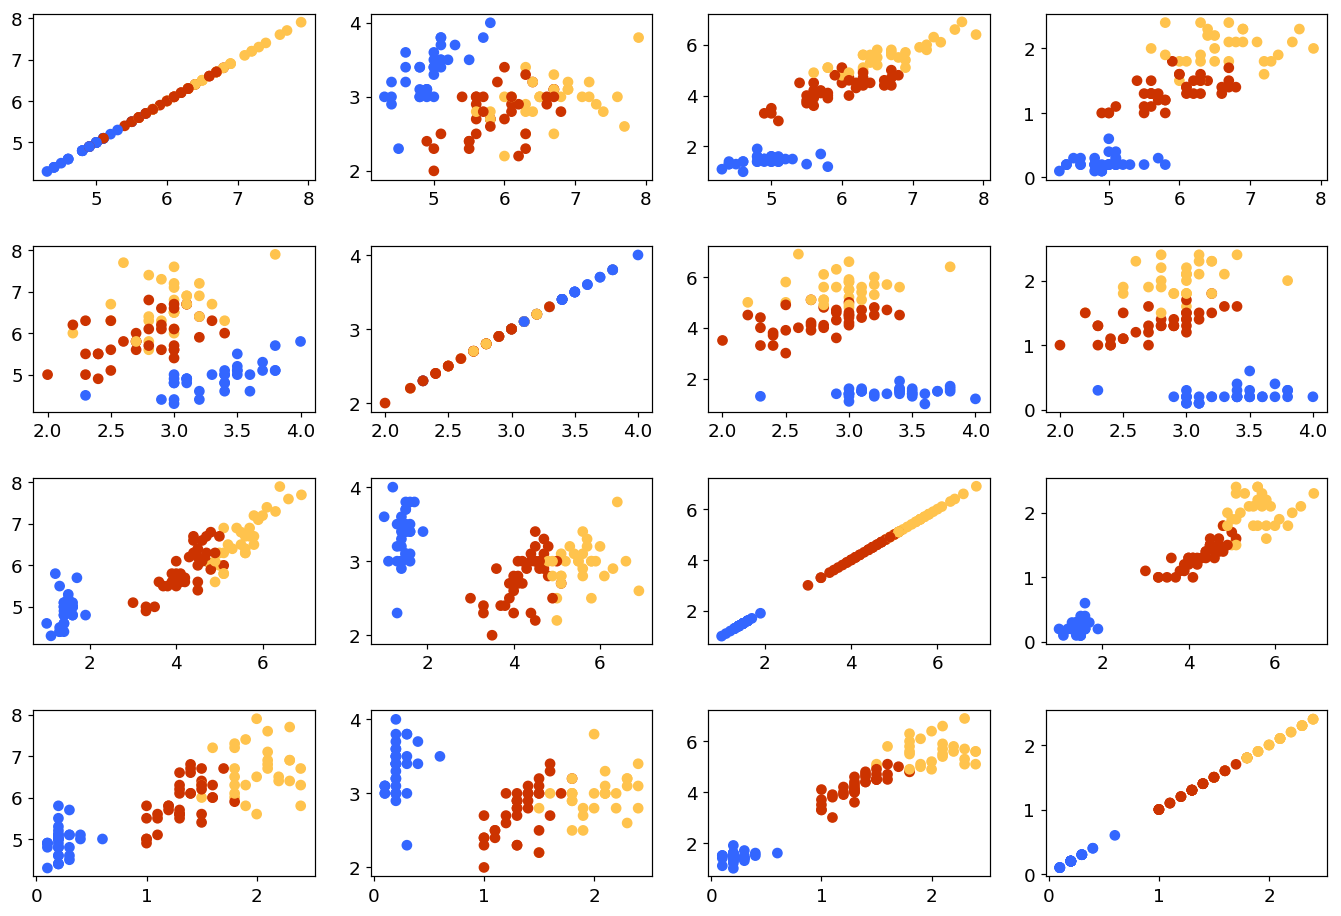

In [5]:
n_features = train_set.shape[1]
fig, ax = plt.subplots(n_features, n_features)
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.2, hspace=0.4)

class_1_colour = r'#3366ff'
class_2_colour = r'#cc3300'
class_3_colour = r'#ffc34d'

class_colours = [class_1_colour, class_2_colour, class_3_colour]
cols = list(map(lambda x: class_colours[x - 1], train_labels))

for ft1 in range(0, n_features):
    for ft2 in range(0, n_features):
        ax[ft1,ft2].scatter(train_set[:,ft1], train_set[:,ft2], c=cols)

## 2. Feature selection

Observe now the scatter plots. As you will notice, certain pairs of features separate the data better than others. This is because the characteristics of the flowers exhibit different degrees of correlation.

Select __two__ features only that, according to you, best separate the data into the respective classes. Note that one class is linearly separable from the others, while the remaining two are not linearly separable from each other. 

Discuss your decision with a TA. Once you have picked up your pair of features, reduce __both__ the training and testing set so that you use only your selected features.

In [6]:
# 3 vs 1
reduced_train_set = train_set[:,[1,3]]
reduced_test_set = test_set[:,[1,3]]

## 3. Nearest-Centroid classifier

Implement the Nearest-Centroid classifier. You will need to follow the steps listed below.

### 3.1. Calculate the centroid for each class, using the reduced training set

In [7]:
import random

"""
def randCent(width, height):
    return (random.randint(0, width), random.randint(0, height))
# turns out this isn't meant to be k-means oops!

def kMeans(points, k):
    cent = list(map(lambda x: randCent(100, 100), [1] * k))
    
    change = 100
    # change threshold?
    while change != 0:
        centBefore = cent.copy()
        # assign each x to the nearest centroid
        assignments = { c:[] for c in cent }
        
        for x in points:
            # calc. distances from all points to all centroids
            dists = [ np.linalg.norm(np.subtract(x,c)) for c in cent ]
            # assign to centroid
            closest = cent[np.argmin(dists)]
            assignments[closest].append(x)
        # recompute each centroid
        for i, c in enumerate(cent):
            if assignments[c] != []:
                all = assignments[c]
                all.append(c)
                new_pos = tuple(np.mean(all, axis=0))
                cent[i] = new_pos
        # calc. change
        #print(centBefore)
        #print(cent)
        change = np.sum(np.subtract(cent, centBefore))
        #print(change)
        
        #print(change)
    return cent

print(kMeans([(1,2), (3,4)], 4))
"""

def count_classes(labels): return len(set(labels))

def calcCentroids(sample, labels):
    # class -> features
    classes = [ [] for i in range(count_classes(labels)) ]
    for idx, x in enumerate(sample):
        cls = labels[idx]
        classes[cls - 1].append(x)
    
    # class -> centroid
    centroids = [ [] for i in range(count_classes(labels)) ]
    for idx, x in enumerate(classes):
        centroids[idx] = np.mean(x, axis=0)
    return centroids

centroids = calcCentroids(reduced_test_set, test_labels)
print(centroids)

[array([3.60625, 0.28125]), array([2.78571429, 1.31428571]), array([3.   , 2.055])]


### 3.2. Display a scatter plot of the reduced training set, along with the calculated centroids 

You should produce a plot similat to the one below (legend included).

![](iris_train.png)

__Hints__:
- Use marker `'o'` with size `300` for the centroids
- Use the list of colours `class_colours` we provided above to distinguish the three classes. 

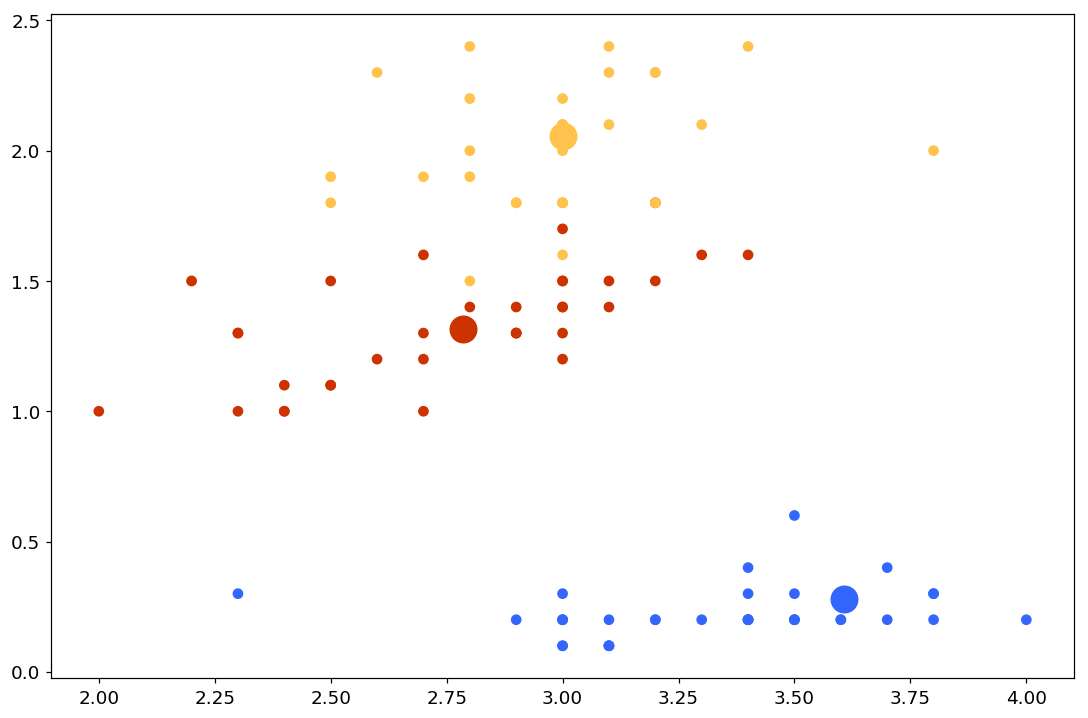

In [8]:
fig, ax = plt.subplots()
for idx, x in enumerate(centroids):
    ax.scatter(x[0], x[1], c=class_colours[idx], s=300)
ax.scatter(reduced_train_set[:,0], reduced_train_set[:,1], c=cols)

### 3.3. Classify each sample in the reduced test set using your classifier. 

Do __NOT__ use the provided test labels to classify the samples. Print the predicted class and the ground truth class for each test sample.

Write your results to a CSV file. __You will need__ this text file for the next lab session, so make sure you save your results! You can use [`np.savetxt(path, results, delimiter=',', fmt='%d')`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savetxt.html) for this purpose. You should save only the predicted class for each sample in the test set.

In [10]:
from collections import defaultdict

# returns idx of closest (i.e. class)
def findClosestCentroid(point, centroids):
    dists = dict()
    for idx, x in enumerate(centroids):
        d = np.linalg.norm(point-x)
        dists[idx] = d
    closest = min(dists, key=dists.get)
    print(dists, '=>', closest)
    return closest

def nearestCentroid(sample, centroids):
    assignments = defaultdict(list)
    print(len(centroids))
    for idx, x in enumerate(reduced_test_set):
        predicted = findClosestCentroid(x, centroids)
        ground = test_labels[idx]
        #print(x, '=>', predicted, '|', ground)
        assignments[predicted].append(x)
    return assignments

assignments = nearestCentroid(reduced_test_set, centroids)
print(assignments)

# for saving
all = []
for c in [0,1,2]:
    for x in assignments[c]:
        all.append([c, *x])
np.savetxt('reduced_test_pred.csv', np.vstack(all), delimiter=',')

3
{0: 0.4142953354794142, 1: 1.1888083555066602, 2: 1.8657505192281199} => 0
{0: 0.5127286075498426, 1: 1.1577599765345608, 2: 1.8576934623344075} => 0
{0: 0.31684479639091373, 1: 1.441371229214793, 2: 1.8838856122387044} => 0
{0: 0.12405895775799475, 1: 1.4413712292147935, 2: 1.9826812653575963} => 0
{0: 0.8025837183746002, 1: 1.8552187835114973, 2: 2.1677234602227284} => 0
{0: 0.31684479639091373, 1: 1.441371229214793, 2: 1.8838856122387044} => 0
{0: 0.22167684813710317, 1: 1.272391288808885, 2: 1.8976366880939035} => 0
{0: 0.37635173043311554, 1: 0.963094502324753, 2: 1.5836745246419792} => 0
{0: 0.22167684813710317, 1: 1.272391288808885, 2: 1.8976366880939035} => 0
{0: 0.4142953354794142, 1: 1.1888083555066602, 2: 1.8657505192281199} => 0
{0: 0.23799290955824773, 1: 1.1014832300686421, 2: 1.7026523426701057} => 0
{0: 0.5259663724992303, 1: 1.7893676913071492, 2: 2.24321755520948} => 0
{0: 0.5992834262684056, 1: 1.8005101317942867, 2: 2.209304189105701} => 0
{0: 0.4142953354794142, 

### 3.4. Display a scatter plot of the reduced test set.

Use the provided test labels to change the colour of each point according to its ground truth class. Overlay a __Voronoi__ plot to display the decision boundaries of your classifier. 

You should produce a plot similar to the one below.

![](iris_test.png)


__Hints__: 
- Use marker `'o'` with size `300` for the centroids
- Use the list of colours `class_colours` we provided above to distinguish the three classes. 
- We are providing you with a function called `plot_voronoi(centroids, test_set, ax)` to plot the Voronoi diagram. This functions takes three parameters:
    - `centroids`: has to be a NumPy array of shape `(3, 2)` containing the centroids' `(x, y)` coordinates
    - `test_set`: has to be a NumPy array of shape `(n, 2)` containing the reducted test set
    - `ax` the matplotlib axis where to overlay the plot. If you create the figure with `fig, fig_ax = plt.subplots()` simply pass `fig_ax`. If you do not explicitily create a figure (i.e. use `plt.plot()` as opposed to `ax.plot()`), then pass `plt.gca()` to the function.

0 :  [3.2 0.2]
0 :  [3.1 0.2]
0 :  [3.9 0.4]
0 :  [3.7 0.2]
0 :  [4.4 0.4]
0 :  [3.9 0.4]
0 :  [3.4 0.2]
0 :  [3.3 0.5]
0 :  [3.4 0.2]
0 :  [3.2 0.2]
0 :  [3.4 0.4]
0 :  [4.1 0.1]
0 :  [4.2 0.2]
0 :  [3.2 0.2]
0 :  [3.5 0.3]
0 :  [3.8 0.4]
1 :  [3.2 1.4]
1 :  [3.1 1.5]
1 :  [2.8 1.5]
1 :  [2.8 1.3]
1 :  [2.7 1.4]
1 :  [3.  1.5]
1 :  [2.2 1. ]
1 :  [2.8 1.2]
1 :  [2.9 1.3]
1 :  [2.9 1.5]
1 :  [2.6 1. ]
1 :  [2.5 1.3]
1 :  [2.6 1.2]
1 :  [2.9 1.3]
1 :  [2.5 1.7]
1 :  [2.6 1.4]
2 :  [3.3 2.5]
2 :  [3.6 2.5]
2 :  [3.2 2. ]
2 :  [2.7 1.9]
2 :  [2.5 2. ]
2 :  [3.8 2.2]
2 :  [2.8 2. ]
2 :  [2.7 1.8]
2 :  [2.8 1.8]
2 :  [2.8 2.1]
2 :  [3.  2.3]
2 :  [3.1 1.8]
2 :  [2.7 1.9]
2 :  [3.2 2.3]
2 :  [3.3 2.5]
2 :  [3.  2.3]
2 :  [3.4 2.3]
2 :  [3.  1.8]


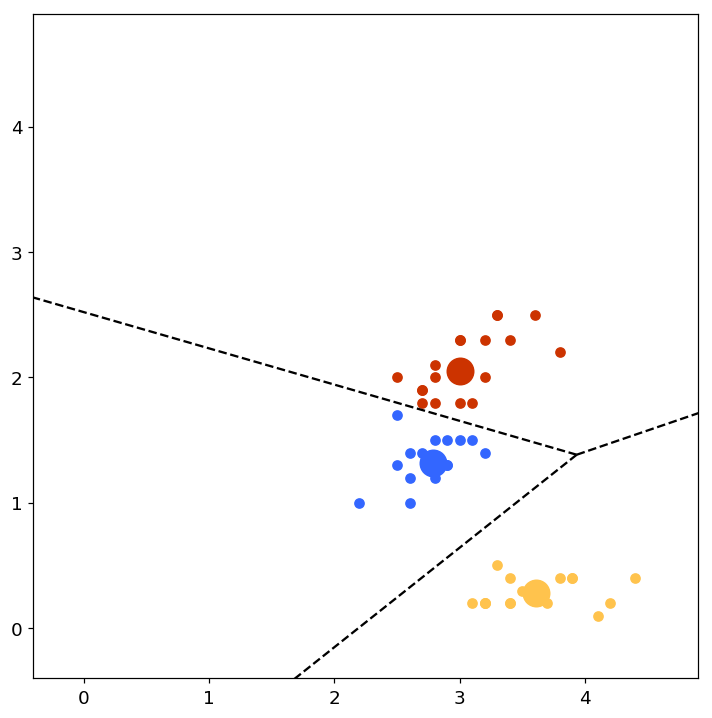

In [11]:
fig, ax = plt.subplots()

#for k, v in centroids.items():
#    ax.scatter(v[0], v[1], c=class_colours[k-1], s=300)

for k, v in assignments.items():
    for x in v:
        print(k,': ',x)
        ax.scatter(x[0], x[1], c=class_colours[k-1])
for idx, x in enumerate(centroids):
    ax.scatter(x[0], x[1], c=class_colours[idx-1], s=300)
        
plot_voronoi(np.vstack((centroids)), reduced_test_set, ax)

### Questions

1. Why are some test points incorrectly classified?
2. How could we change our classifier so that all the test points are correctly classified?
3. Would having all the test points correctly classified necessarily be a good thing?
4. Our simple dataset was fully labelled and thus we could follow a supervised approach. This made our life much easier. Suppose now we did not have any class labels for the training set, and that we still wanted to use the Nearest-Centroid classifier. How could we train our classifier in such case?


### Answers 

Write your answers here